In [3]:
import numpy as np

import cvxpy as cp

from qutip import coherent, ket2dm, Qobj, expect, fidelity, fock, fock_dm, displace
from qutip.visualization import plot_wigner_fock_distribution, plot_wigner
from qutip.wigner import wigner

from tqdm.auto import tqdm # progress bar

import matplotlib.pyplot as plt
from matplotlib import colors

### Define Wigner measurement operators

In [46]:
def wigner_ops(hilbert_size, betas):
    """
    Constructs a list of measurement operators for the Wigner function
    measurement at beta values.

    Args:
        hilbert_size (int): The hilbert size dimension for the operators
        betas (list/array): N complex values to construct the operator

    Returns:
        ops_list (list): A list of (N, hilbert_size, hilbert_size) for N ops
    """
    parity_op = sum([((-1)**i)*fock_dm(50, i) for i in range(hilbert_size)])
    ops_list = []

    for beta in tqdm(betas):
        D = displace(50, beta) # need the larger Hilbert space to not get erroneous operators for large beta
        A = D*parity_op*D.dag()
        op = (A)*(2/np.pi)
        op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        ops_list.append(op)

    return ops_list

### Read measurement data

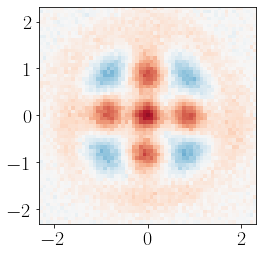

In [47]:
wig_binomial = np.load('experimental_wigner_data/wig_binomial_61x61.npy')

xvec = np.load('experimental_wigner_data/xvec_binomial_61x61.npy')
xmin = np.min(xvec)
xmax = np.max(xvec)

norm = colors.TwoSlopeNorm(vmin = -2/np.pi, vcenter=0, vmax=2/np.pi)

plt.imshow(wig_binomial, cmap="RdBu_r", norm=norm, extent=[xmin, xmax, xmin, xmax]);

b = wig_binomial.flatten()

### Measurement settings
The coherent probe states $|\beta\rangle$ on a square grid in phase space.

In [48]:
X, Y = np.meshgrid(xvec, xvec)

# flatten the grid of probe states into a 1D array
betas = (X + 1j*Y).ravel()

### Construct the operator basis: Fock basis
The list `basis_dms` contains all $\Omega_k$

In [49]:
# Set Fock space dimension
N = 10

# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

#### Assign measurement operators $\Pi$ with the measurement settings

In [50]:
%%time
Pis = wigner_ops(N, betas)

  0%|          | 0/3721 [00:00<?, ?it/s]

CPU times: user 22min, sys: 37min 24s, total: 59min 25s
Wall time: 3min 56s


### Construct the matrix A in $A\vec\rho=\vec b$
From `Pis` and `basis_dms`.

In [51]:
A = np.zeros((len(Pis), N*N), dtype=np.complex64)

for index, a in tqdm(np.ndenumerate(A)):
    A[index] = np.trace(Pis[index[0]].full() @ basis_dms[index[1]])


0it [00:00, ?it/s]

## Convex optimization

Define the unknown state as a $N\times N$ Hermitian matrix

In [52]:
X = cp.Variable((N,N), hermitian=True)

Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.reshape(X, (N*N))`

In [53]:
cost = cp.norm(A @ cp.reshape(X, (N*N)) - b, 2);

Set the trace constraint and positive-semidefinite constraint, respectively.

In [54]:
constraints = [cp.trace(X) == 1, X >> 0 ]

Set up and solve the problem!

In [55]:
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve()

WARN: A->p (column pointers) not strictly increasing, column 3777 empty
WARN: A->p (column pointers) not strictly increasing, column 3788 empty
WARN: A->p (column pointers) not strictly increasing, column 3799 empty
WARN: A->p (column pointers) not strictly increasing, column 3810 empty
WARN: A->p (column pointers) not strictly increasing, column 3821 empty
WARN: A->p (column pointers) not strictly increasing, column 3832 empty
WARN: A->p (column pointers) not strictly increasing, column 3843 empty
WARN: A->p (column pointers) not strictly increasing, column 3854 empty
WARN: A->p (column pointers) not strictly increasing, column 3865 empty
WARN: A->p (column pointers) not strictly increasing, column 3876 empty


1.6231198558174107

In [56]:
# Assign the optimized state X to a Qobj.

reconstructed_rho = Qobj(X.value)

### Visualize results

Plot the reconstructed state and show the fidelity

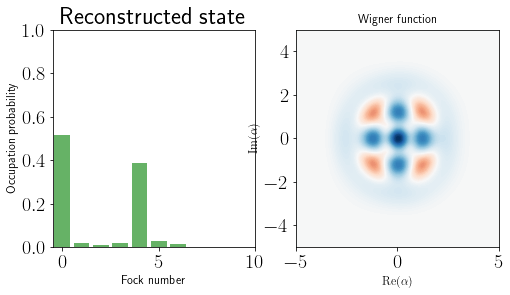

In [57]:
alpha_max = 5
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=alpha_max)
ax[0].set_title("Reconstructed state");

### Check fidelity to target state

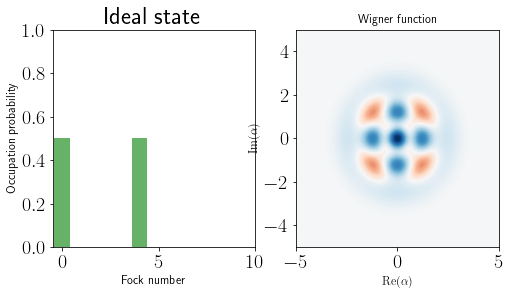

In [58]:
ideal_state = (fock(N,0) + fock(N,4)).unit()
fig, ax = plot_wigner_fock_distribution(ideal_state, alpha_max=alpha_max)
ax[0].set_title("Ideal state");

Similar fidelity as in the [publication](https://arxiv.org/abs/2111.07965).

In [59]:
F = fidelity(ideal_state, reconstructed_rho)
print("Fidelity:", F)

Fidelity: 0.9482368283609282
